In [1]:
# Import Python modules and connect to a SQL database

import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date

%load_ext sql
%sql sqlite://

%matplotlib inline

In [2]:
# Define a function to read the given CSV file with Pandas, 
# and then return the DataFrame

def load_file(name, parse_dates=None):
    path = 'clean_f1db/' + name
    encoding = 'ISO-8859-1'
    if not parse_dates:
        return pd.read_csv(path)
    return pd.read_csv(path, parse_dates=parse_dates)

In [3]:
# Load the CSV files and create SQL tables

drivers = load_file('drivers.csv')
%sql PERSIST drivers

constr = load_file('constructors.csv')
%sql PERSIST constr

results = load_file('results.csv')
%sql PERSIST results

 * sqlite://
 * sqlite://
 * sqlite://


'Persisted results'

## SQL Table vs Pandas DataFrame
Notice the similarities between the two.

In [4]:
%sql SELECT * FROM drivers LIMIT 5;

 * sqlite://
Done.


index,driverId,driverRef,number,code,forename,surname,dob,nationality,url
0,1,hamilton,44.0,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
1,2,heidfeld,None,HEI,Nick,Heidfeld,1977-05-10,German,http://en.wikipedia.org/wiki/Nick_Heidfeld
2,3,rosberg,6.0,ROS,Nico,Rosberg,1985-06-27,German,http://en.wikipedia.org/wiki/Nico_Rosberg
3,4,alonso,14.0,ALO,Fernando,Alonso,1981-07-29,Spanish,http://en.wikipedia.org/wiki/Fernando_Alonso
4,5,kovalainen,None,KOV,Heikki,Kovalainen,1981-10-19,Finnish,http://en.wikipedia.org/wiki/Heikki_Kovalainen


In [5]:
drivers.head()

,driverId,driverRef,number,code,forename,surname,dob,nationality,url
0,1,hamilton,44.0,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
1,2,heidfeld,NaN,HEI,Nick,Heidfeld,1977-05-10,German,http://en.wikipedia.org/wiki/Nick_Heidfeld
2,3,rosberg,6.0,ROS,Nico,Rosberg,1985-06-27,German,http://en.wikipedia.org/wiki/Nico_Rosberg
3,4,alonso,14.0,ALO,Fernando,Alonso,1981-07-29,Spanish,http://en.wikipedia.org/wiki/Fernando_Alonso
4,5,kovalainen,NaN,KOV,Heikki,Kovalainen,1981-10-19,Finnish,http://en.wikipedia.org/wiki/Heikki_Kovalainen


## Problem 1
Find the most successful constructors in F1 by race wins and plot the results.

In [6]:
%%sql

-- Find the total number of race wins for each constructor.
-- Only keep the top 10, this makes it easier to view the pie chart.
-- A win here means position = 1.

SELECT name, COUNT(*) AS count
  FROM results AS r
  JOIN constr AS c
    ON r.constructorId = c.constructorId
 WHERE position = 1
 GROUP BY r.constructorId
 ORDER BY count DESC
 LIMIT 10;

 * sqlite://
Done.


name,count
Ferrari,236
McLaren,178
Williams,114
Mercedes,96
Red Bull,61
Team Lotus,45
Renault,35
Benetton,27
Tyrrell,23
Brabham,23


In [7]:
# We can do the same with Pandas to verify the results

df = results[results['position'] == 1]
df = df.groupby('constructorId').agg('count')
df = df.join(constr.set_index('constructorId'))

In [8]:
# Both methods produced the same result, but which one is easier to read?

df = df[['name', 'resultId']].sort_values('resultId', ascending=False)
df = df.head(10)
df

,name,resultId
constructorId,,
6,Ferrari,236
1,McLaren,178
3,Williams,114
131,Mercedes,96
9,Red Bull,61
32,Team Lotus,45
4,Renault,35
22,Benetton,27
25,Tyrrell,23


Text(0.5, 1.0, 'Number of Race Wins in Formula 1')

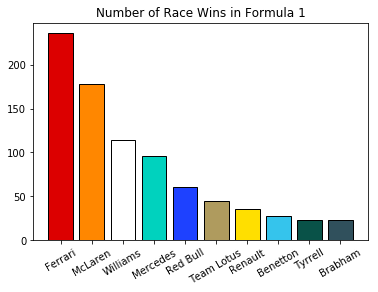

In [9]:
'''
Now we can produce a bar chart using the DataFrame. Since Matplotlib allows 
us to specify colors in the pie chart, we can use the colors that represent 
these teams.

Credits to www.f1colours.com, html-color-codes.info/colors-from-image/, and
www.reddit.com/r/formula1/comments/arxt0r/f1_2019_team_colors_hex_codes/
for the team colors.
'''

colors = ['#DC0000', '#FF8700', '#FFFFFF', '#00D2BE', '#1E41FF', 
          '#AF9B5E', '#FFDF00', '#35C4EC', '#095248', '#30505C']

plt.xticks(rotation=30)
plt.bar(df['name'], df['resultId'], color=colors, edgecolor='#000000');
plt.title('Number of Race Wins in Formula 1')

## Problem 2
Find the most successful constructors in F1 by win rate and plot the results.

Win rate is defined by number of race wins divided by number of race entries.

In [10]:
%%sql 

-- Similar to the previous query, first find the number of race wins
-- Then compute the number of race entries and divide

WITH race_wins(consId, wins) AS 
     (SELECT constructorId, COUNT(*)
        FROM results
       WHERE position = 1
       GROUP BY constructorId)


SELECT name, 
       ROUND(1.0 * W.wins / COUNT(*), 3) AS win_rate
  FROM constr AS c
       JOIN results AS r
       ON c.constructorId = r.constructorId
        
       JOIN race_wins AS w
       ON r.constructorId = w.consId
 GROUP BY r.constructorId
 ORDER BY win_rate DESC
 LIMIT 10;

 * sqlite://
Done.


name,win_rate
Brawn,0.235
Mercedes,0.23
Matra-Ford,0.225
Vanwall,0.141
Watson,0.136
Epperly,0.118
Red Bull,0.11
Ferrari,0.107
McLaren,0.105
Brabham-Repco,0.104


<BarContainer object of 10 artists>

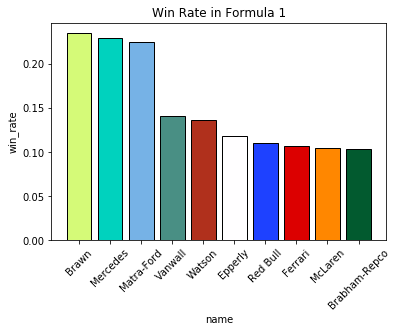

In [11]:
colors = ['#D5FA78', '#00D2BE', '#76B2E6', '#498F84', '#B0301C', 
          '#FFFEFF', '#1E41FF', '#DC0000', '#FF8700', '#025A2F']

plt.title('Win Rate in Formula 1')
_.bar(color=colors, edgecolor='#000000')

## Problem 3
Is the number of races each season increasing?

In [12]:
# Load races.csv as a DataFrame

races = load_file('races.csv')
%sql PERSIST races

races.head()

 * sqlite://


,raceId,year,round,circuitId,name,date,time,url
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Gran...
3,4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Gran...
4,5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Gran...


In [13]:
# Group by 'year'

df = races.groupby('year').aggregate('count').reset_index()

In [14]:
# Find a best fit line

fit = stats.linregress(df['year'], df['raceId'])
df['fit'] = fit.slope * df['year'] + fit.intercept

Text(0, 0.5, 'Number of Races')

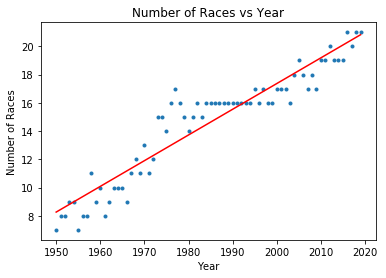

In [15]:
# Take a look at the results, is the slope increasing?

plt.plot(df['year'], df['raceId'], '.')
plt.plot(df['year'], df['fit'], 'r-')
plt.title('Number of Races vs Year')
plt.xlabel('Year')
plt.ylabel('Number of Races')

## Problem 4
Find all drivers that have won a drivers' championship title with Ferrari. 

In [16]:
%%sql

-- For every season, find each driver's total points.
-- Store the results of this query so we can use it again later.

CREATE TEMP TABLE standings(consId INT, drivId INT, year INT, points INT);

INSERT INTO Standings
SELECT constructorId, driverId, 
       year, SUM(points)
  FROM results AS re
  JOIN races AS ra
    ON re.raceId = ra.raceId
 GROUP BY driverId, year;

 * sqlite://
Done.
3099 rows affected.


[]

In [17]:
%%sql

-- The drivers that have scored the most points in a season are the
-- driver's champion. Keep entries where constructor name is Ferrari.

-- The sorting order of year is quite intersting.

WITH champions(consId, drivId, year) AS 
     (SELECT consId, drivId, 
             s.year
        FROM standings AS s
        JOIN (SELECT year, 
                     MAX(points) AS points
                FROM standings 
               GROUP BY year) AS ms
          ON s.year = ms.year
             AND s.points = ms.points)

    
SELECT forename, 
       surname,
       d.nationality, 
       ch.year
  FROM champions AS ch
  JOIN constr AS co
    ON ch.consId = co.constructorId
    
  JOIN drivers AS d
    ON ch.drivId = d.driverId
 WHERE co.name = 'Ferrari';

 * sqlite://
Done.


forename,surname,nationality,year
Kimi,Räikkönen,Finnish,2007
Michael,Schumacher,German,2000
Michael,Schumacher,German,2001
Michael,Schumacher,German,2002
Michael,Schumacher,German,2003
Michael,Schumacher,German,2004
Niki,Lauda,Austrian,1975
Niki,Lauda,Austrian,1977
Jody,Scheckter,South African,1979
Phil,Hill,American,1961


## Problem 5
Some drivers were very close to winning a title with Ferrari.

Find the ones that lost by no more than five points.

In [18]:
%%sql

-- Similar to the previous query, but instead of finding standings where
-- points = MAX(points), find ones where 0 < (points - MAX(points)) <= 5.

WITH close_champions(consId, drivId, year, points) AS 
     (SELECT consId, drivId, 
             s.year,
             ms.points - s.points
        FROM standings AS s
        JOIN (SELECT year, 
                     MAX(points) AS points
                FROM standings 
               GROUP BY year) AS ms
          ON s.year = ms.year
       WHERE s.points <> ms.points
         AND ms.points - s.points <= 5)

SELECT forename, surname,
       d.nationality, 
       ch.year, points
  FROM close_champions AS ch
  JOIN constr AS co
    ON ch.consId = co.constructorId
    
  JOIN drivers AS d
    ON ch.drivId = d.driverId
 WHERE co.name = 'Ferrari';

 * sqlite://
Done.


forename,surname,nationality,year,points
Fernando,Alonso,Spanish,2010,4
Fernando,Alonso,Spanish,2012,3
Felipe,Massa,Brazilian,2008,1
Michael,Schumacher,German,1997,3
Eddie,Irvine,British,1999,2
Alain,Prost,French,1990,5
Niki,Lauda,Austrian,1976,1
Didier,Pironi,French,1982,5
Clay,Regazzoni,Swiss,1974,3
Jacky,Ickx,Belgian,1970,5


In [19]:
%%sql

-- Now remove the temporary table that was created earlier.

DROP TABLE Standings;

 * sqlite://
Done.


[]

## Problem 6
Find all drivers to win a race before the age of 24.

In [20]:
# Issue: driver's date of birth has a different format than race dates.
# We must convert them to the same format. We can do this by reading 
# the csv files again with the parse_dates argument.

ddrivers = load_file('drivers.csv', parse_dates=['dob'])

%sql PERSIST ddrivers

draces = load_file('races.csv', parse_dates=['date'])

%sql PERSIST draces

ddrivers['dob'].head(), draces['date'].head()

 * sqlite://
 * sqlite://


(0   1985-01-07
 1   1977-05-10
 2   1985-06-27
 3   1981-07-29
 4   1981-10-19
 Name: dob, dtype: datetime64[ns], 0   2009-03-29
 1   2009-04-05
 2   2009-04-19
 3   2009-04-26
 4   2009-05-10
 Name: date, dtype: datetime64[ns])

In [21]:
%%sql 

-- Not quite right, we are missing Raikkonen, Kubica, and Fittipaldi
-- This could be a rounding error, as these drivers are included in
-- the results when date - dob < 25.

SELECT DISTINCT forename, surname
  FROM results re
  JOIN ddrivers d
    ON re.driverId = d.driverId
    
  JOIN draces r
    ON re.raceId = r.raceId
 WHERE position = 1
   AND date - dob < 24;

 * sqlite://
Done.


forename,surname
Lewis,Hamilton
Sebastian,Vettel
Fernando,Alonso
Michael,Schumacher
Jacky,Ickx
Bruce,McLaren
Troy,Ruttman
Max,Verstappen


In [22]:
%%sql

-- Joining the tables in Python then calculating the time delta
-- doesn't return the correct results either.

-- Idea: Join tables in SQL and compute the time delta in Python.

SELECT DISTINCT forename, surname,
       MIN(date) AS date, dob
  FROM results re
  JOIN ddrivers d
    ON re.driverId = d.driverId
    
  JOIN draces r
    ON re.raceId = r.raceId
 WHERE position = 1
   AND date - dob < 25
 GROUP BY forename, surname;

 * sqlite://
Done.


forename,surname,date,dob
Bruce,McLaren,1959-12-12 00:00:00.000000,1937-08-30 00:00:00.000000
David,Coulthard,1995-09-24 00:00:00.000000,1971-03-27 00:00:00.000000
Elio,de Angelis,1982-08-15 00:00:00.000000,1958-03-26 00:00:00.000000
Emerson,Fittipaldi,1970-10-04 00:00:00.000000,1946-12-12 00:00:00.000000
Fernando,Alonso,2003-08-24 00:00:00.000000,1981-07-29 00:00:00.000000
Jacky,Ickx,1968-07-07 00:00:00.000000,1945-01-01 00:00:00.000000
Jody,Scheckter,1974-06-09 00:00:00.000000,1950-01-29 00:00:00.000000
Kimi,Räikkönen,2003-03-23 00:00:00.000000,1979-10-17 00:00:00.000000
Lewis,Hamilton,2007-06-10 00:00:00.000000,1985-01-07 00:00:00.000000
Max,Verstappen,2016-05-15 00:00:00.000000,1997-09-30 00:00:00.000000


In [23]:
# Convert the query results to a DataFrame

df = _.DataFrame()

In [24]:
# After the convertion 'date' and 'dob' are stored as strings,
# so convert them back to datetime format.

def convert2time(str):
    return datetime.strptime(str[:10], '%Y-%m-%d')

df['date'] = df['date'].apply(convert2time)
df['dob'] = df['dob'].apply(convert2time)

In [25]:
# Finally, calculate the drivers' age when they won the race
# and keep all entries where age < 24. 

df['age'] = df['date'] - df['dob']
df = df[df['age'] < timedelta(days=365*24)]

df = df[['forename', 'surname']].drop_duplicates()

In [26]:
df

,forename,surname
0,Bruce,McLaren
3,Emerson,Fittipaldi
4,Fernando,Alonso
5,Jacky,Ickx
7,Kimi,Räikkönen
8,Lewis,Hamilton
9,Max,Verstappen
10,Michael,Schumacher
12,Robert,Kubica
13,Sebastian,Vettel
